Processing frame 72/72.

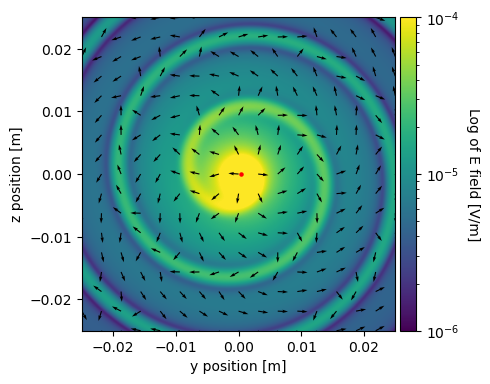

In [46]:
'''
Using the dipole gif example from Pycharge https://github.com/physics2023/pycharge
the code was rewritten to produce a gif using the cyclotron function.
A custom charge can be made in Pycharge to show the fields produced by a custom trajectory.
In addition, other fields can also be visualized and multiple electrons can be added using superposition.
'''
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

import pycharge as pc

lim = 0.025
grid_size = 2500 # the resolution can be set lower to speed up computation
x, y, z = np.meshgrid(np.linspace(-lim, lim, grid_size), np.linspace(-lim, lim, grid_size),
                      0, indexing='ij')

# the thesis B-field is oriented in the x-direction but this one in the z-direction
charge = pc.OrbittingCharge(radius=0.46e-3, omega=2*np.pi*27e9)
simulation = pc.Simulation(charge)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_position([0, 0, 1, 1])

# Scalar plot
im = ax.imshow(np.zeros((grid_size, grid_size)), origin='lower', 
               extent=[-lim, lim, -lim, lim], interpolation='nearest', 
               norm=LogNorm(vmin=1e-6, vmax=1e-4))

ax.set_xlabel("y position [m]")
ax.set_ylabel("z position [m]")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
cax.set_ylabel('Log of E field [V/m]', rotation=270, labelpad=15)

# Quiver plot
grid_size_quiver = 17
x_quiver, y_quiver, z_quiver = np.meshgrid(
    np.linspace(-lim, lim, grid_size_quiver),
    np.linspace(-lim, lim, grid_size_quiver),
    0, indexing='ij')

# following the particle using a red dot
Q = ax.quiver(x_quiver, y_quiver, x_quiver[:, :, 0], y_quiver[:, :, 0], scale_units='xy')
pos = ax.scatter(charge.xpos(0), charge.ypos(0), s=5, c='red', marker='o')

def _update_animation(frame):
    text = f"\rProcessing frame {frame+1}/{n_frames}."
    sys.stdout.write(text)
    sys.stdout.flush()
    t = frame*dt
    E_total = simulation.calculate_E(t=t, x=x, y=y, z=z, pcharge_field='Total')
    u = E_total[0][:, :, 0]
    v = E_total[1][:, :, 0]
    im.set_data(np.sqrt(u**2+v**2).T)
    E_total = simulation.calculate_E(
        t=t, x=x_quiver, y=y_quiver, z=z_quiver, pcharge_field='Total')
    u = E_total[0][:, :, 0]
    v = E_total[1][:, :, 0]
    r = np.power(np.add(np.power(u, 2), np.power(v, 2)), 0.5)
    Q.set_UVC(u/r, v/r)
    pos.set_offsets((charge.xpos(t), charge.ypos(t)))
    return im

def _init_animate():
    """Necessary for matplotlib animate."""
    pass  # pylint: disable=unnecessary-pass


n_frames = 24*3 # Number of frames
dt = 2*np.pi/charge.omega/n_frames
fig.set_tight_layout(True)
ani = FuncAnimation(fig, _update_animation, repeat=True, frames=n_frames, blit=False, init_func=_init_animate)
writervideo = animation.PillowWriter(fps=24)
plt.autoscale()
#ani.save(r'cyclotron.gif', writer=writervideo, dpi=300)